## Comparing CEDS and SNEII inventories in OsloCTM3
### PM2.5 plots

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
#import xesmf as xe
from matplotlib import rcParams
import pandas as pd
import regionmask
import geopandas as gp
import cartopy.feature as cfeature
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import LinearSegmentedColormap
import matplotlib

ERROR 1: PROJ: proj_create_from_database: Cannot find proj.db


In [2]:
#define file locations
file_loc1 = '/div/pdo/mariantl/QUISARC/osloctm3_newIndEmis/dta2nc/'

#***change filename here***
filename1 = 'OsloCTM3_pm25_load3d_monthly_2018_CEDS21.nc'
filename2 = 'OsloCTM3_pm25_load3d_monthly_2018_CEDS21_SNEII.nc'

outfile = '/div/nac/users/zofias/plots/SNEII/'

In [3]:
# import shape file for states
zipfile = "/div/no-backup/users/zofias/India_State_Boundary.shp"
states = gp.read_file(zipfile)

In [4]:
#states

In [5]:
rcParams['font.size'] = 16

time_months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'] #[1,2,3,4,5,6,7,8,9,10,11,12]
month_labs = ['J','F','M','A','M','J','J','A','S','O','N','D']

### Import data

In [6]:
#import data
ds_ceds = xr.open_dataset(f'{file_loc1}{filename1}')
ds_sneii = xr.open_dataset(f'{file_loc1}{filename2}')

#calculate difference
ds_diff = ds_sneii - ds_ceds

In [7]:
ds_ceds

<xarray.Dataset>
Dimensions:  (lat: 80, lon: 160, lev: 60, time: 12)
Coordinates:
  * lat      (lat) float32 -88.75 -86.37 -84.12 -81.87 ... 84.12 86.37 88.75
  * lon      (lon) float32 0.5625 2.812 5.062 7.312 ... 351.6 353.8 356.1 358.3
  * lev      (lev) float32 998.8 995.9 991.5 985.3 ... 0.7964 0.5104 0.2921 0.11
Dimensions without coordinates: time
Data variables:
    area     (lat, lon) float32 ...
    PM2.5    (time, lev, lat, lon) float32 ...
Attributes:
    Comment:        Concentrations from OsloCTM3
    contact:        m.t.lund@cicero.uio.no
    creation_date:  2024-12-3

In [8]:
#make mask for regions
lon = np.arange(-180, 180)
lat = np.arange(-90, 90)

mask = regionmask.mask_geopandas(states, lon, lat)

/tmp/ipykernel_667014/840373041.py:5: UserWarning: No gridpoint belongs to any region. Returning an all-NaN mask.
  mask = regionmask.mask_geopandas(states, lon, lat)


In [9]:
#import area dataset for area weighted mean
#ds_area = xr.open_dataset('/div/nac/users/zofias/ACACIA/OsloCTM3_80_160_areacella.nc')
ds_delta_z = xr.open_dataset('/div/nac/users/zofias/ACACIA/OsloCTM3_80_160_delta_z.nc')

box_area = ds_ceds["area"]
delta_z = ds_delta_z["delta_z"]*-1

ds_landmask = xr.open_dataset('/div/no-backup/users/zofias/landsea_OsloCTMres.nc')

ds_landmask['lat'] = ds_sneii.lat
ds_landmask['lon'] = ds_sneii.lon


weights_lat_lon_3d = np.array(60*[box_area.data]) # weights for 12 months
#weights_lat_lon_2d = box_area.data

In [10]:
#obs station labels and locations
station_lat_lons = np.array([[77.2,28.68],[76.37,30.35],[73.72,24.58],[79.97,23.15],[73.8,18.53],[78.4,17.52],[91.65,26.15],[80.13,13.03]])
station_labs = ['Delhi','Patiala','Udaipur','Jabalpur','Pune','Hyderabad','Guwahati','Chennai']

#city labels and locations
city_names = ['Mumbai','Delhi','Kolkata','Chennai','Bengalūru','Hyderabad']
city_lat_lons = np.array([[72.836447, 18.987807],[77.231495, 28.651952], [88.363044, 22.562627],[80.248357, 13.084622],[77.587106, 12.977063],[78.456355, 17.384052]])

### Calculations: averaging, surface conc, column

In [11]:
calcs = {
    "CEDS": xr.Dataset(),
    "diff": xr.Dataset(),
    "SNEII": xr.Dataset()
}

models = {
    "CEDS": ds_ceds,
    "diff": ds_diff,
    "SNEII": ds_sneii
}

model_list = ["CEDS", "diff", "SNEII"]

In [12]:
#define constants
mr_o3 = 48.
mr_air = 28.97
n_a = 6.022e23

In [13]:
#select surface concs
for exp in model_list:
    exp_ukca = models[exp]
    exp_calc = calcs[exp]
    #print(exp_ukca)
    #print(exp_ukca[")

    exp_calc["pm25_surf"] = (
        exp_ukca['PM2.5'] 
        .isel(lev = 0)
        *1e9 #convert to  ug m-3
    )

In [14]:
#land mask
for exp in model_list:
    exp_ukca = models[exp]
    exp_calc = calcs[exp]
    #print(exp_ukca)
    #print(exp_ukca[")
    
    exp_calc["pm25_land_masked"] = (
        exp_calc.pm25_surf.where(ds_landmask.LSMASK > 0.9)
        .load()
    )

In [15]:
#select surface conc and calculate mean
for exp in model_list:
    exp_calc = calcs[exp]
    
    exp_calc["pm25_india_land_mean"] = (
        exp_calc["pm25_land_masked"]
        .sel(lon=slice(65, 95), lat=slice(6, 35))
        .weighted(box_area)
        .mean(dim=('lat','lon'))
        .load()
    )

In [16]:
calcs['SNEII']

<xarray.Dataset>
Dimensions:               (lat: 80, lon: 160, time: 12)
Coordinates:
  * lat                   (lat) float32 -88.75 -86.37 -84.12 ... 86.37 88.75
  * lon                   (lon) float32 0.5625 2.812 5.062 ... 353.8 356.1 358.3
    lev                   float32 998.8
Dimensions without coordinates: time
Data variables:
    pm25_surf             (time, lat, lon) float32 0.4652 0.4664 ... 0.6435
    pm25_land_masked      (time, lat, lon) float32 0.4652 0.4664 ... nan nan
    pm25_india_land_mean  (time) float32 38.58 34.14 34.45 ... 29.76 33.09 41.02

### Plots

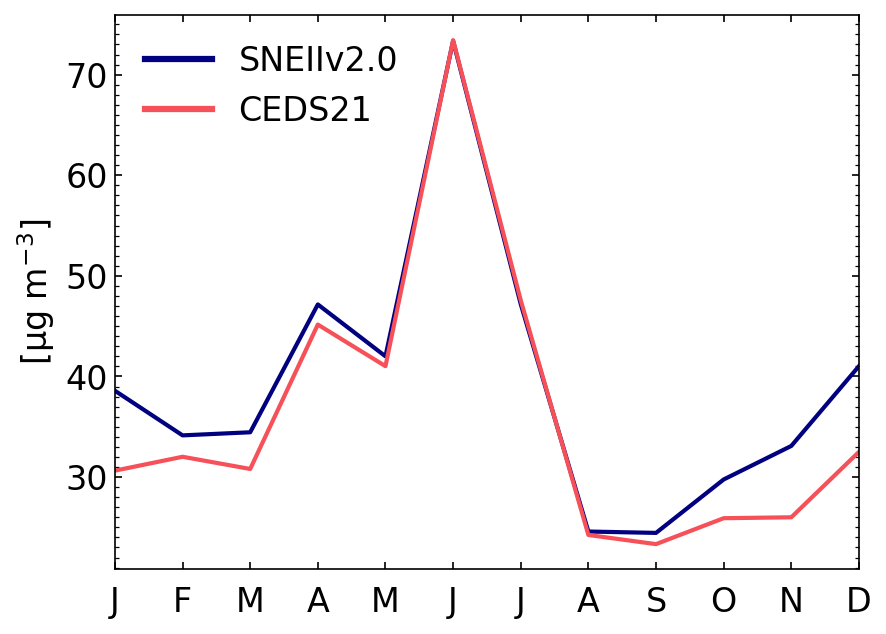

In [17]:
fig = plt.figure(dpi=150)
ax = plt.axes()

calcs['SNEII'].pm25_india_land_mean.plot(label = 'SNEIIv2.0', c= (0,0,128/255),linewidth=2)
calcs['CEDS'].pm25_india_land_mean.plot(label = 'CEDS21', c=(246/255,80/255,88/255),linewidth=2)


#ax.spines['right'].set_visible(False)
#ax.spines['top'].set_visible(False)

# chart formatting
ax.set_xlim(0,11)
ax.set_xticks(calcs['CEDS'].pm25_india_land_mean.time.data,month_labs)
plt.title('')
ax.set_xlabel('')
ax.set_ylabel(r"[μg m$^{{-3}}$]")
leg = plt.legend(frameon=False,loc=2)
#ax.set_yticks(minor=True)
ax.xaxis.set_tick_params(direction='in', which='both',top=True,pad=8)
ax.yaxis.set_tick_params(direction='in', which='both',right=True)

ax.yaxis.set_minor_locator(MultipleLocator(1))
#ax.tick_params(axis='y', which='minor', bottom=False)


for legobj in leg.legendHandles:
    legobj.set_linewidth(3)

#plt.gca().set_aspect(0.45)
#plt.savefig(f'{outfile}SNEII_CEDS_o3_surface_india_mean_land_masked_clim.pdf',format='pdf',bbox_inches='tight')


In [18]:
cmap_ol_pu_bk = LinearSegmentedColormap.from_list('Random gradient 442', (
    # Edit this gradient at https://eltos.github.io/gradient/#Random%20gradient%20442=0:FFFFFF-25:B6B610-60:7A7AF3-100:000000
    (0.000, (1.000, 1.000, 1.000)),
    (0.250, (0.714, 0.714, 0.063)),
    (0.600, (0.478, 0.478, 0.953)),
    (1.000, (0.000, 0.000, 0.000))))

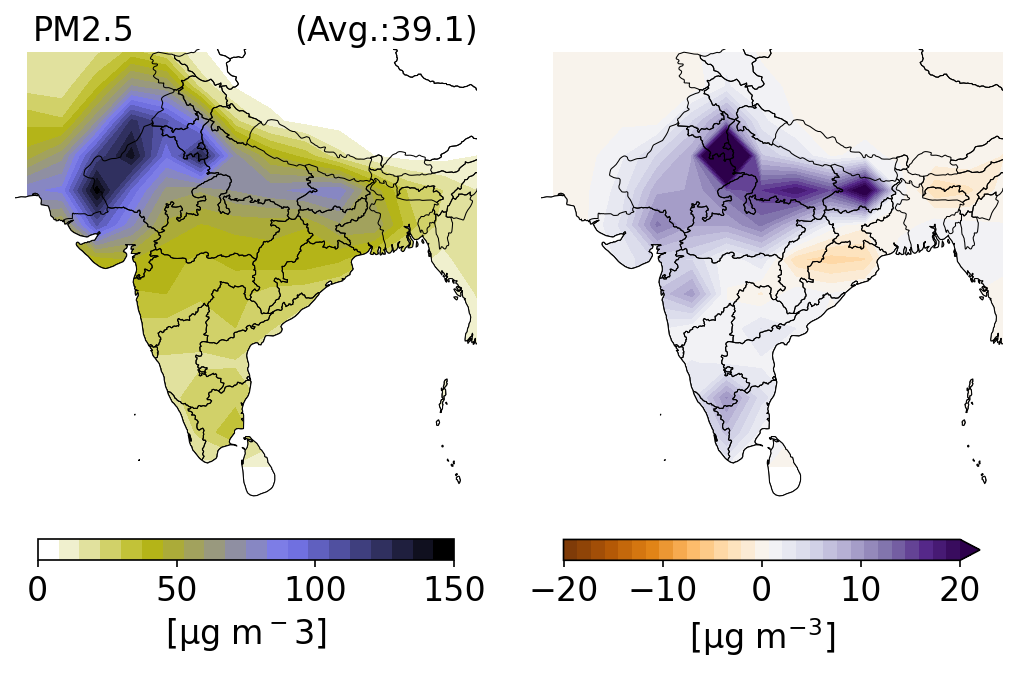

In [27]:
fig, axs = plt.subplots(1, 2, dpi=150, subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(9, 5))

# Plot 1: SNEII surface map
ax = axs[0]
fg1 = calcs['SNEII'].pm25_surf.mean(dim='time').sel(lon=slice(65, 96), lat=slice(6, 35)).plot.contourf(
    ax=ax, cmap=cmap_ol_pu_bk, vmax=150, vmin=0,
    levels=21, add_colorbar=False
)
cbar1 = fig.colorbar(fg1, ax=ax, label=f"[μg m$^{-3}$]", location='bottom', pad=0.05, shrink=0.8, ticks=np.arange(0, 151,50))
cbar1.ax.xaxis.set_minor_locator(plt.NullLocator())

ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.OCEAN, zorder=4, edgecolor='k', linewidth=0.5, facecolor='w')
ax.set_title("")
ax.set_extent([65, 95, 5, 35], crs=ccrs.PlateCarree())
ax.axis("off")

plt.text(32,35.5,f'PM2.5')
plt.text(49,35.5,f"(Avg.:{calcs['SNEII'].pm25_india_land_mean.mean():.1f})")

# Plot 2: Difference map
ax = axs[1]
fg2 = calcs['diff'].pm25_surf.mean(dim='time').sel(lon=slice(65, 96), lat=slice(6, 35)).plot.contourf(
    ax=ax, cmap="PuOr", vmax=20, vmin=-20, 
    levels=30, add_colorbar=False
)
cbar2 = fig.colorbar(fg2, ax=ax, label=r"[μg m$^{{-3}}$]", location='bottom', pad=0.05, shrink=0.8, ticks=np.arange(-20, 21, 10))
cbar2.ax.xaxis.set_minor_locator(plt.NullLocator())
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.OCEAN, zorder=4, edgecolor='k', linewidth=0.5, facecolor='w')
ax.set_title("")
ax.set_extent([65, 95, 5, 35], crs=ccrs.PlateCarree())
ax.axis("off")


plt.subplots_adjust(wspace=0.01)



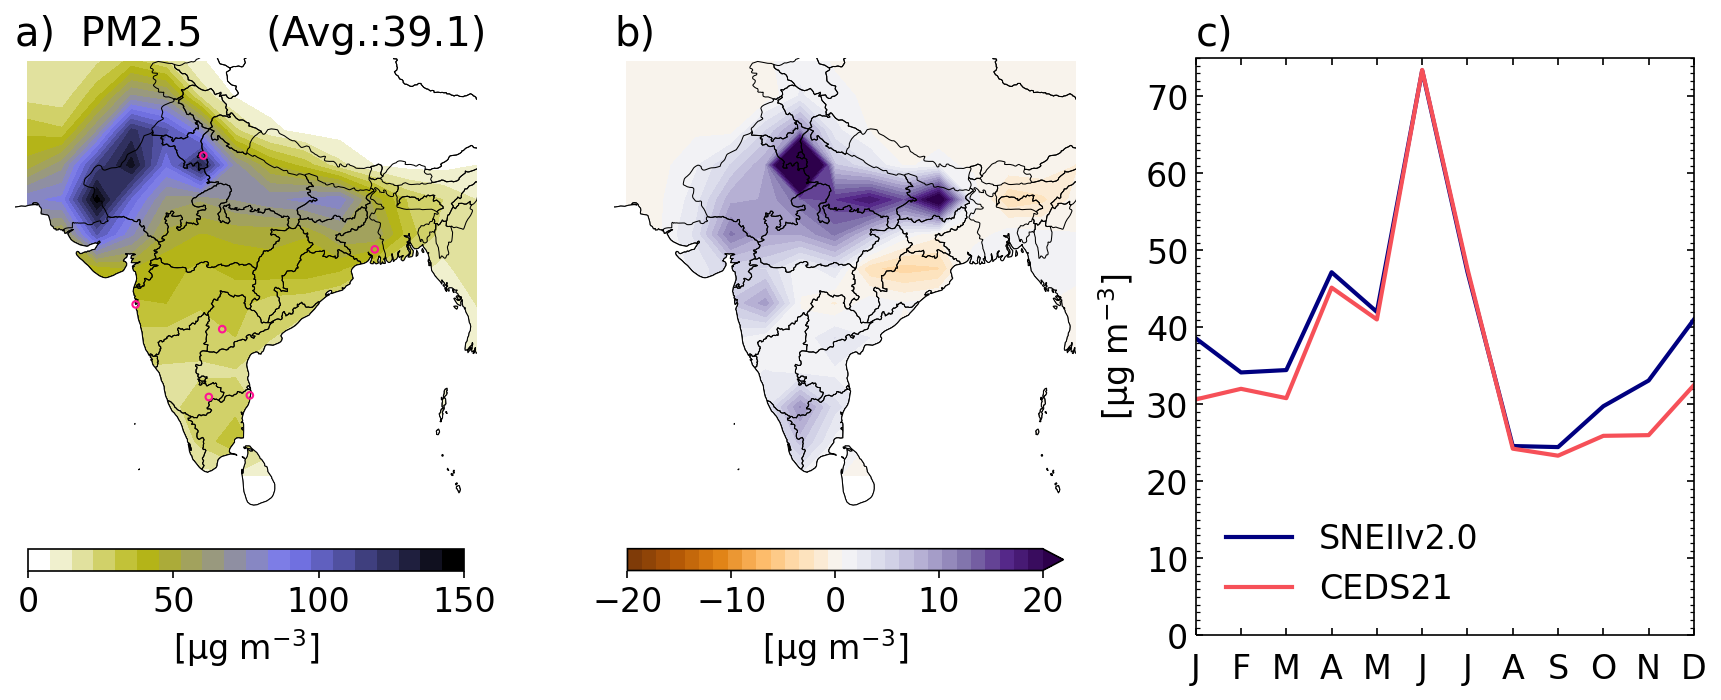

In [ ]:
fig, axs = plt.subplots(1, 3, dpi=150, subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(15, 5))


# Ammonium
ax = axs[0]
fg1 = calcs['SNEII'].pm25_surf.mean(dim='time').sel(lon=slice(65, 96), lat=slice(6, 35)).plot.contourf(
    ax=ax, cmap=cmap_ol_pu_bk, vmax=150,vmin=0,
    levels=21, add_colorbar=False
)
cbar1 = fig.colorbar(fg1, ax=ax, label=r"[μg m$^{{-3}}$]", location='bottom', pad=0.05, shrink=0.8, ticks=np.arange(0, 151,50))
cbar1.ax.xaxis.set_minor_locator(plt.NullLocator())
ax.set_title('')
ax.set_title(f"a)  PM2.5     (Avg.:{calcs['SNEII'].pm25_india_land_mean.mean():.1f})", loc='left')
#ax.set_title(f"(Avg.:{calcs['SNEII'].NH4_india_land_mean.mean():.1f})", loc='right')
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.scatter(city_lat_lons[:,0],city_lat_lons[:,1],marker='o',facecolors='none',edgecolors='deeppink',zorder=10,s=10)
ax.add_feature(cfeature.OCEAN, zorder=4, edgecolor='k', linewidth=0.5, facecolor='w')
#ax.set_title(f"e)  Ammonium (Avg.:{calcs['SNEII'].NH4_india_land_mean.mean():.1f})")
ax.set_extent([65, 95, 5, 35], crs=ccrs.PlateCarree())
ax.axis("off")


# Plot 2: Difference map
ax = axs[1]
fg2 = calcs['diff'].pm25_surf.mean(dim='time').sel(lon=slice(65, 96), lat=slice(6, 35)).plot.contourf(
    ax=ax, cmap="PuOr", vmax=20, vmin=-20, 
    levels=30, add_colorbar=False
)
cbar2 = fig.colorbar(fg2, ax=ax, label=r"[μg m$^{{-3}}$]", location='bottom', pad=0.05, shrink=0.8, ticks=np.arange(-20, 21,10))
cbar2.ax.xaxis.set_minor_locator(plt.NullLocator())
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.OCEAN, zorder=4, edgecolor='k', linewidth=0.5, facecolor='w')
ax.set_title('')
ax.set_title(f"b)", loc='left')
ax.set_extent([65, 95, 5, 35], crs=ccrs.PlateCarree())
ax.axis("off")

ax = axs[2]
calcs['SNEII'].pm25_india_land_mean.plot(ax=ax, label = 'SNEIIv2.0', c= (0,0,128/255),linewidth=2)
calcs['CEDS'].pm25_india_land_mean.plot(ax=ax, label = 'CEDS21', c=(246/255,80/255,88/255),linewidth=2)

# chart formatting
ax.set_xlim(0,11)
ax.set_ylim(0,75)
ax.set_xticks(calcs['CEDS'].pm25_india_land_mean.time.data)
ax.set_xticklabels(month_labs)
ax.set_xlabel('')
ax.set_ylabel(r"[μg m$^{{-3}}$]")
ax.set_title('')
ax.set_title(f"c)", loc='left')
ax.set_yticks(np.arange(0,75,10))
leg = plt.legend(frameon=False)
ax.xaxis.set_tick_params(direction='in', which='both',top=True,pad=8)
ax.yaxis.set_tick_params(direction='in', which='both',right=True)
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.set_aspect(0.17)

#plt.tight_layout()
plt.subplots_adjust(wspace=0.1)
#plt.savefig(f'{outfile}Fig2_pm25_surf_SNEII_diff_landmean.pdf',format='pdf',bbox_inches='tight')